# Before you start...

In this notebook you'll be using the `auto-sklearn` library. You need to install it using the command below. After the command is finished executing, make sure you restart the runtime. 

In [ ]:
!pip install auto-sklearn

# Building a Baseline Model for Kaggle's Heart Disease Dataset

To build a baseline model means to develop a minimally-viable model as quickly as possible. The key here is, "non-trivial". The  model must not be useless. This is a crucial step in machine learning after exploratory data analysis is performed. Generally, baseline models require no feature engineering. However, the features are processed minimally such that machine learning models will not get choked up on the data.   

Often times, a business needs a model out in production fast. Something is better than nothing and frequently, a baseline model is sufficient. If a business decides to add additional resources to improve the model, the baseline provides foundational metrics to improve upon.  

In this notebook, you'll be guided through several approaches towards building baseline models. You'll also be exposed to several metrics used to gauge the efficacy of classification models. You'll use the [Kaggle Heart Disease Dataset](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data), which first appeared in the UCI data repository. 

# Load the Data

First, import the libraries we'll be using. 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix

Load the Kaggle Heart Disease dataset. 

In [ ]:
heart_df = pd.read_csv('/content/heart_disease.zip')

Split the data into a training and test set using `train_test_split`.

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(
        heart_df.iloc[:, ~heart_df.columns.isin(['target'])], 
        heart_df['target'], 
        test_size=0.3,
        random_state=42,
        shuffle=True
        )
    )

# Majority Class Baseline

One of the simplest baseline models one can create is by always predicting the most frequent class. If the most frequent class occurs 50% of the time then your model will be 50% accurate! For unbalanced datasets (e.g. cancer prediction), where positive labels are relatively rare, consistently choosing the majority class will yield even better accuracy. For this reason, accuracy is not always a good metric to gauge a model's performance.  

The F1 measure, which balances precision and recall, is typically a much better indicator of model performance for classification problems such as Kaggle's Heart Disease prediction.  

**Exercise:** Determine the majority class in the heart disease dataset. 

**Exercise:** Calculate the F1 score on the test set where the predicted labels are always the majority class. Use Scikit-Learn's `f1_score` function. Is this a performant model? 


In [ ]:
y_train.value_counts(normalize=True)

1    0.525802
0    0.474198
Name: target, dtype: float64

In [ ]:
y_pred = [1]*y_test.shape[0]

In [ ]:
f1_score(y_test, y_pred)

0.6520787746170679

# XGBoost Classifier Baseline

XGBoost stands for Extreme Gradient Boosting and is an open source implementation of gradient-boosted decision trees. Virtually all winners of Kaggle competitions with tabular datasets have utilized some form of XGBoost. NVIDIA provides an excellent overview of XGBoost and its benefits [here](https://www.nvidia.com/en-us/glossary/data-science/xgboost/). 

Some advantages of XGBoost:
* Do not need normalized features 
* Works well on non-linear data
* Has an in-built capability to handle null values
* Highly parallelizable 

As you can see from the list above, XGBoost is an excellent candidate for building a baseline model because little to no feature engineering is required to get a good model. 

**Exercise:** Use `XGBClassifier` to train a model on the heart disease dataset. Make sure to set `random_state` for resproducible results. Using f1 score as a metric (use scikit-learns `f1_score`), how does the model perform on the test set? 

**Exercise:** One disadvantage of XGBoost is that it tends to overfit data when its hyperparameters aren't tuned properly. Calculate the f1 score on the train dataset and compare to the value obtained on the test data. Is your model overfitting?

**Exercise:** The confusion matrix can yield extremely valuable insights on model performance. Generate a confusion matrix for your model's performance on the test set. From the confusion matrix, how many true positives were found? False positives? False negatives? What's the precision? What's the recall? Finally, can you reproduce the f1 score from precision and recall using the value in the first exercise? 

**Exercise:** An ROC curve is a useful visual for gauging model performance, as it balances the true positive rate and false positive rate of your model based on various prediction thresholds. This is an important note. Most classification algorithms output a probability for the target variables. By default, for binary classification, the threshold is set to 0.5. In other words, if the algorithm outputs a probability greater than 0.5 then the positive label is output. Otherwise, the negative label is output. By changing this threshold the model's performance metrics change. Generate an ROC curve using sklearn's `RocCurveDisplay`. What's the area under the curve? If your model were to output completely random labels, what would the ROC curve look like? Finally, what point on the ROC curve should you operate at for best performance? 
 

In [ ]:
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [ ]:
f1_score(y_test, y_pred)

0.9664429530201343

Are you overfitting?

In [ ]:
f1_score(y_train, xgb_model.predict(X_train))

0.9867724867724869

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
cm

array([[144,   5],
       [  5, 154]])

In [ ]:
true_pos = cm[0][0]
false_pos = cm[0][1]
false_neg = cm[1][0]
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
2 * precision * recall / (precision + recall)

0.9664429530201343

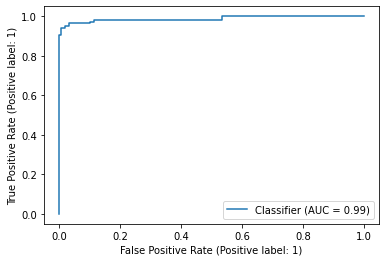

In [ ]:
RocCurveDisplay.from_predictions(y_test, xgb_model.predict_proba(X_test)[:, 1]);

In [ ]:
roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

0.9869148621839517

# AutoML Baseline

AutoML stands for Automated Machine Learning, and is yet another good approach for developing a baseline model. Most AutoML libraries will take care of feature selection, model selection, composition, and hyperparameter tuning. 

Most Cloud providers have some sort of AutoML capability that can easily be integrated into a business' ETL pipeline. For example, AWS has [SageMaker Autopilot](aws.amazon.com/sagemaker/autopilot/).

You might ask, what's the purpose of learning all this ML stuff if AutoML can just do it for us? While AutoML is extremely powerful, you still have to understand how the model performs, be able to ensure it generalizes to new data, and provide the pipeline to feed data.

In this exercise you'll be using the open source [Auto-Sklearn](https://automl.github.io/auto-sklearn/master/) to build a baseline model on the heart disease dataset. 

**Exercise:** Use the `AutoSklearnClassifier` to build an AutoML model for the heart disease dataset. Make sure you set a reasonable time limit for this classifier to build. Once the classifier's training is complete, calculate its performance on the test set using the f1 score. How does it compare to other baseline models you've created? 

Note, the [Pareto Principle](https://en.wikipedia.org/wiki/Pareto_principle) applies to ML development. Many practitioners have noted that in ML you'll spend 80% of your time trying to get the elusive 20% boost in performance.

In [ ]:
from autosklearn.classification import AutoSklearnClassifier

In [ ]:
automl = AutoSklearnClassifier(time_left_for_this_task=300)
automl.fit(X_train, y_train)
y_pred = automl.predict(X_test)

In [ ]:
f1_score(y_test, y_pred)

0.9863945578231292

# Models will Learn...

It's important to know that, by design, machine learning algorithms will find correlations between any feature set and target variables, even if there aren't any. This is due to random noise and statistical fluctuations. Any machine learning model worth its weight should be able to out perform a similar model trained purely on noise. 

**Exercise:** Write a loop that trains `XGBClassifier` on the training data 100 times. But there's a catch. For each iteration, randomly shuffle the labels so that the only relationship between the features and target variable is random noise. Use numpy's `random.shuffle` to do the shuffling. Also, for each iteration, calculate the f1 score on the test set and store it in a list. Plot a histogram of f1 scores. How do the values compare to your other baseline models?   

**Exercise:** As you may have guessed `train_test_split` only offers one of many possible partitions of data. It's useful to see that the particular partition can have a large effect on the trained model's performance. Write a loop that trains `XGBClassifier` on 100 different training data sets. Use `train_test_split` but don't set the `random_state`. For each iteration, calculate the f1 score on the test set and plot the distribution using a histogram. How much variability do you see in model performance? 

## Shuffling the labels

In [ ]:
y_train_shuffled = y_train.values
f1_scores_shuffled = []
for i in range(100):
  np.random.shuffle(y_train_shuffled)
  xgb_model = xgb.XGBClassifier(random_state=42)
  xgb_model.fit(X_train, y_train_shuffled)
  y_pred = xgb_model.predict(X_test)
  f1_scores_shuffled.append(f1_score(y_test, y_pred))

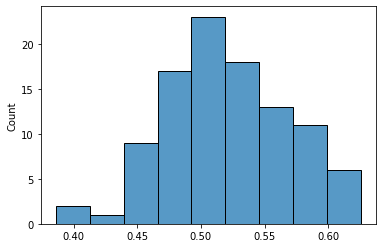

In [ ]:
sns.histplot(data=f1_scores_shuffled);

## Training on Different Splits

In [ ]:
f1_scores = []
for i in range(100):
  X_train, X_test, y_train, y_test = (
    train_test_split(
        heart_df.iloc[:, ~heart_df.columns.isin(['target'])], 
        heart_df['target'], 
        test_size=0.3,
        shuffle=True
        )
    )
  xgb_model = xgb.XGBClassifier(random_state=42)
  xgb_model.fit(X_train, y_train)
  y_pred = xgb_model.predict(X_test)
  f1_scores.append(f1_score(y_test, y_pred))

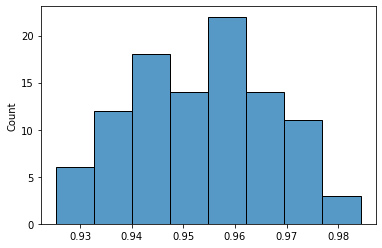

In [ ]:
sns.histplot(data=f1_scores);